In [41]:
# !pip install mxnet
# !pip install gluonnlp pandas tqdm
# !pip install sentencepiece
# !pip install transformers # 최신 버전으로 설치하면 "Input: must be Tensor, not str" 라는 에러 발생
# !pip install torch

In [42]:
# !pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [43]:
# !apt-get update

# !apt-get install g++ openjdk-8-jdk python-dev python3-dev

# !pip3 install JPype1-py3

# !pip3 install konlpy

# !JAVA_HOME = /Library/Java/JavaVirtualMachines/zulu-15.jdk/Contents/Home

# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [44]:
# !pip install ipywidgets  # for vscode
# !pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [45]:
# !pip uninstall torch
# !pip install torch==1.12.1

In [46]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup


In [47]:
## CPU
#device = torch.device("cpu")

device = torch.device("cuda:0")

In [48]:
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [49]:
import pandas as pd
df = pd.read_csv('/content/홍대_맛집_리뷰_데이터_ver5.csv')
df.head()

,Unnamed: 0,name,average_rating,user,user_rating,comment,url,target
0,0,후계동,4.5,풀내음,5.0,NaN,https://place.map.kakao.com/1183957472,1
1,1,후계동,4.5,ㅇㅇ,5.0,❤️❤️❤️❤️❤️,https://place.map.kakao.com/1183957472,1
2,2,후계동,4.5,핑구,5.0,오래 해주세요🙏,https://place.map.kakao.com/1183957472,1
3,3,후계동,4.5,:ᴅ,3.0,웨이팅해서 먹을 맛은 아니에요… 닭보쌈은 보통이었고 비빔국수라고 해서 당연히 국물 ...,https://place.map.kakao.com/1183957472,0
4,4,후계동,4.5,Vin,5.0,와 여길 왜 이제알았죠! 너무맛있고 반찬 하나하나 다 맛있네요!! 자주 갈게요!,https://place.map.kakao.com/1183957472,1


In [50]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      3130 non-null   int64  
 1   name            3130 non-null   object 
 2   average_rating  3130 non-null   float64
 3   user            3127 non-null   object 
 4   user_rating     3130 non-null   float64
 5   comment         2529 non-null   object 
 6   url             3130 non-null   object 
 7   target          3130 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 195.8+ KB


In [51]:
df.duplicated(['comment'])

0       False
1       False
2       False
3       False
4       False
        ...  
3125     True
3126     True
3127     True
3128     True
3129    False
Length: 3130, dtype: bool

In [52]:
df.drop_duplicates(['comment'])

,Unnamed: 0,name,average_rating,user,user_rating,comment,url,target
0,0,후계동,4.5,풀내음,5.0,NaN,https://place.map.kakao.com/1183957472,1
1,1,후계동,4.5,ㅇㅇ,5.0,❤️❤️❤️❤️❤️,https://place.map.kakao.com/1183957472,1
2,2,후계동,4.5,핑구,5.0,오래 해주세요🙏,https://place.map.kakao.com/1183957472,1
3,3,후계동,4.5,:ᴅ,3.0,웨이팅해서 먹을 맛은 아니에요… 닭보쌈은 보통이었고 비빔국수라고 해서 당연히 국물 ...,https://place.map.kakao.com/1183957472,0
4,4,후계동,4.5,Vin,5.0,와 여길 왜 이제알았죠! 너무맛있고 반찬 하나하나 다 맛있네요!! 자주 갈게요!,https://place.map.kakao.com/1183957472,1
...,...,...,...,...,...,...,...,...
3120,3120,혼가츠홍대,2.9,조에,5.0,음식이 가격대비 양도 많고 맛있는 곳입니다!!!분위기랑 직원들의 반응이 중요하신 분...,https://place.map.kakao.com/22895023,1
3122,3122,혼가츠홍대,2.9,maya,1.0,여기 알바들이 설쳐대는게 아니라면 방송 탔었다고 이리 리뷰가 많은것인가요? 진심 평...,https://place.map.kakao.com/22895023,0
3123,3123,혼가츠홍대,2.9,어쩜,2.0,음. 웨이팅 십오분했는데 차게 식은 치즈가스가 나왔다. 왕혼가츠도 그냥 쏘쏘.,https://place.map.kakao.com/22895023,0
3124,3124,혼가츠홍대,2.9,이정훈,5.0,가격은 양에비해서 싸거나 적당하다고 봅니다. 기본 생돈까스는 정말 양이 많슴니다.,https://place.map.kakao.com/22895023,1


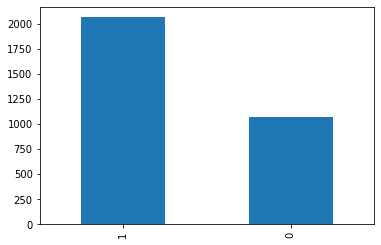

In [53]:
df['target'].value_counts().plot(kind = 'bar')

## 결측치 제거

In [54]:
df.isnull().sum()

Unnamed: 0          0
name                0
average_rating      0
user                3
user_rating         0
comment           601
url                 0
target              0
dtype: int64

In [55]:
df = df.dropna()
df.isnull().sum()

Unnamed: 0        0
name              0
average_rating    0
user              0
user_rating       0
comment           0
url               0
target            0
dtype: int64

## 데이터 정제

In [56]:
df['comment'] = df['comment'].str.replace("[^ㄱ-하-ㅣ가-힣 ]", '')

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,name,average_rating,user,user_rating,comment,url,target
1,1,후계동,4.5,ㅇㅇ,5.0,,https://place.map.kakao.com/1183957472,1
2,2,후계동,4.5,핑구,5.0,오래 해주세요,https://place.map.kakao.com/1183957472,1
3,3,후계동,4.5,:ᴅ,3.0,웨이팅해서 먹을 맛은 아니에요 닭보쌈은 보통이었고 비빔국수라고 해서 당연히 국물 없...,https://place.map.kakao.com/1183957472,0
4,4,후계동,4.5,Vin,5.0,와 여길 왜 이제알았죠 너무맛있고 반찬 하나하나 다 맛있네요 자주 갈게요,https://place.map.kakao.com/1183957472,1
5,5,후계동,4.5,손민영,5.0,오늘의 메뉴 너무 좋아요 어쩜 갖가지 닭요리를 그렇게 잘하시죠 이런 리뷰 잘 안 남...,https://place.map.kakao.com/1183957472,1


In [57]:
df['comment'] = df['comment'].replace('', np.nan)
len(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


2527

In [58]:
df.isnull().sum()

Unnamed: 0        0
name              0
average_rating    0
user              0
user_rating       0
comment           5
url               0
target            0
dtype: int64

In [59]:
 # 정규표현식으로 인해 공백이 된 리뷰 행 제거
df = df.dropna()
len(df)

2522

In [60]:
df.head(10)

,Unnamed: 0,name,average_rating,user,user_rating,comment,url,target
2,2,후계동,4.5,핑구,5.0,오래 해주세요,https://place.map.kakao.com/1183957472,1
3,3,후계동,4.5,:ᴅ,3.0,웨이팅해서 먹을 맛은 아니에요 닭보쌈은 보통이었고 비빔국수라고 해서 당연히 국물 없...,https://place.map.kakao.com/1183957472,0
4,4,후계동,4.5,Vin,5.0,와 여길 왜 이제알았죠 너무맛있고 반찬 하나하나 다 맛있네요 자주 갈게요,https://place.map.kakao.com/1183957472,1
5,5,후계동,4.5,손민영,5.0,오늘의 메뉴 너무 좋아요 어쩜 갖가지 닭요리를 그렇게 잘하시죠 이런 리뷰 잘 안 남...,https://place.map.kakao.com/1183957472,1
6,6,후계동,4.5,장슐랭가이드,1.0,여기서 밥먹고 둘다 장염걸림,https://place.map.kakao.com/1183957472,0
7,7,후계동,4.5,이우진,5.0,최애 식당진짜 다 맛있고 가격이 엄청 착함오늘의 메뉴라고 매일 새로운 메뉴가 준비되...,https://place.map.kakao.com/1183957472,1
8,8,후계동,4.5,정찰병,4.0,다음부터 사장님 김치볶음밥하지마세요 ㅠ ㅜ 라면만 하세요하실꺼면 진짜 딴거말고 김치...,https://place.map.kakao.com/1183957472,1
9,9,후계동,4.5,쿠집사,5.0,이렇게 맛있어도 되나 할 정도로 맛있어요ㅎㅎ,https://place.map.kakao.com/1183957472,1
10,10,후계동,4.5,Sungjin Ji,5.0,오늘의 메뉴닭 카레라이스미니 어묵 우동둘 다 맛있다 카레는 일본식 아니고 우리식 우...,https://place.map.kakao.com/1183957472,1
11,11,후계동,4.5,손손,5.0,닭보쌈이 특히 예술 매일 해주시면 좋겠는데 오늘의메뉴여야 맛볼 수 있음,https://place.map.kakao.com/1183957472,1


In [61]:
df.drop(['Unnamed: 0', 'name', 'average_rating', 'user', 'user_rating', 'url'], axis=1, inplace=True)
df.head(10)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,comment,target
2,오래 해주세요,1
3,웨이팅해서 먹을 맛은 아니에요 닭보쌈은 보통이었고 비빔국수라고 해서 당연히 국물 없...,0
4,와 여길 왜 이제알았죠 너무맛있고 반찬 하나하나 다 맛있네요 자주 갈게요,1
5,오늘의 메뉴 너무 좋아요 어쩜 갖가지 닭요리를 그렇게 잘하시죠 이런 리뷰 잘 안 남...,1
6,여기서 밥먹고 둘다 장염걸림,0
7,최애 식당진짜 다 맛있고 가격이 엄청 착함오늘의 메뉴라고 매일 새로운 메뉴가 준비되...,1
8,다음부터 사장님 김치볶음밥하지마세요 ㅠ ㅜ 라면만 하세요하실꺼면 진짜 딴거말고 김치...,1
9,이렇게 맛있어도 되나 할 정도로 맛있어요ㅎㅎ,1
10,오늘의 메뉴닭 카레라이스미니 어묵 우동둘 다 맛있다 카레는 일본식 아니고 우리식 우...,1
11,닭보쌈이 특히 예술 매일 해주시면 좋겠는데 오늘의메뉴여야 맛볼 수 있음,1


In [62]:
df.reset_index(inplace = True)

In [63]:
df

,index,comment,target
0,2,오래 해주세요,1
1,3,웨이팅해서 먹을 맛은 아니에요 닭보쌈은 보통이었고 비빔국수라고 해서 당연히 국물 없...,0
2,4,와 여길 왜 이제알았죠 너무맛있고 반찬 하나하나 다 맛있네요 자주 갈게요,1
3,5,오늘의 메뉴 너무 좋아요 어쩜 갖가지 닭요리를 그렇게 잘하시죠 이런 리뷰 잘 안 남...,1
4,6,여기서 밥먹고 둘다 장염걸림,0
...,...,...,...
2517,3119,양이 생각보다 적어서 좀 실망ㅠㅠ맛은 좋은데양을 늘려주면 좋겠다치즈까스는 인정 하겠음 ㅎ,0
2518,3120,음식이 가격대비 양도 많고 맛있는 곳입니다분위기랑 직원들의 반응이 중요하신 분들은 ...,1
2519,3122,여기 알바들이 설쳐대는게 아니라면 방송 탔었다고 이리 리뷰가 많은것인가요 진심 평생...,0
2520,3123,음 웨이팅 십오분했는데 차게 식은 치즈가스가 나왔다 왕혼가츠도 그냥 쏘쏘,0


In [64]:
df.drop(['index'],axis=1, inplace=True)
df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,comment,target
0,오래 해주세요,1
1,웨이팅해서 먹을 맛은 아니에요 닭보쌈은 보통이었고 비빔국수라고 해서 당연히 국물 없...,0
2,와 여길 왜 이제알았죠 너무맛있고 반찬 하나하나 다 맛있네요 자주 갈게요,1
3,오늘의 메뉴 너무 좋아요 어쩜 갖가지 닭요리를 그렇게 잘하시죠 이런 리뷰 잘 안 남...,1
4,여기서 밥먹고 둘다 장염걸림,0
...,...,...
2517,양이 생각보다 적어서 좀 실망ㅠㅠ맛은 좋은데양을 늘려주면 좋겠다치즈까스는 인정 하겠음 ㅎ,0
2518,음식이 가격대비 양도 많고 맛있는 곳입니다분위기랑 직원들의 반응이 중요하신 분들은 ...,1
2519,여기 알바들이 설쳐대는게 아니라면 방송 탔었다고 이리 리뷰가 많은것인가요 진심 평생...,0
2520,음 웨이팅 십오분했는데 차게 식은 치즈가스가 나왔다 왕혼가츠도 그냥 쏘쏘,0


In [65]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df,test_size=0.2, random_state=42)
print("train shape is:", len(train))
print("test shape is:", len(test))

train shape is: 2017
test shape is: 505


In [66]:
train.to_csv('hongik_food_train.txt', index=False, sep="\t")
test.to_csv('hongik_food_test.txt', index=False, sep="\t")

In [67]:
dataset_train = nlp.data.TSVDataset("/content/hongik_food_train.txt", field_indices=[0,1], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset("/content/hongik_food_test.txt", field_indices=[0,1], num_discard_samples=1)

## 토크나이저 선택

In [68]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [69]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair) 

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [70]:
# Setting parameters
max_len = 246 # 해당 길이를 초과하는 단어에 대해선 bert가 학습하지 않음
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [71]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [72]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [73]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [74]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [75]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [76]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [77]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [78]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [79]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [80]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  0%|          | 0/32 [00:00<?, ?it/s]


RuntimeError: ignored